In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

In [2]:
df = pd.read_excel('RawObesityDataset.xlsx')
# Shuffle the data

In [3]:
from sklearn.preprocessing import LabelEncoder

# I am a bit uncomfortable with the idea of encoding binary features to 1 and 2.
# Instead, I mapped them to 1 and 0
df['Sex'] = df['Sex'].map({1.0: 1, 2.0: 0})
df['Overweight_Obese_Family'] = df['Overweight_Obese_Family'].map({1.0: False, 2.0: True})
df['Smoking'] = df['Smoking'].map({1.0: False, 2.0: True})
df['Calculation_of_Calorie_Intake'] = df['Calculation_of_Calorie_Intake'].map({1.0: False, 2.0: True})

In [4]:
from sklearn.preprocessing import StandardScaler

continuous_features = [
    'Age',
    'Height',
    'Consumption_of_Fast_Food',
    'Frequency_of_Consuming_Vegetables',
    'Number_of_Main_Meals_Daily',
    'Food_Intake_Between_Meals',
    'Liquid_Intake_Daily',
    'Physical_Excercise',
    'Schedule_Dedicated_to_Technology',
    'Type_of_Transportation_Used']
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
# Save the DataFrame to Excel
df.to_excel("adjusted_dataset.xlsx", index=False)
obesity_data = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(obesity_data['Type_of_Transportation_Used'])

0      -1.098269
1       0.878124
2       0.878124
3      -1.098269
4       0.878124
          ...   
1605    1.536922
1606   -1.098269
1607    0.878124
1608   -1.098269
1609   -0.439471
Name: Type_of_Transportation_Used, Length: 1610, dtype: float64


In [6]:
X = obesity_data[['Sex', 'Age', 'Height', 'Overweight_Obese_Family', 'Consumption_of_Fast_Food', 'Frequency_of_Consuming_Vegetables', 'Number_of_Main_Meals_Daily', 'Food_Intake_Between_Meals', 'Smoking', 'Liquid_Intake_Daily', 'Calculation_of_Calorie_Intake', 'Physical_Excercise', 'Schedule_Dedicated_to_Technology', 'Type_of_Transportation_Used']]
y = obesity_data['Class']
#print(obesity_data.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

In [8]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [3, 5, 11], 
    'min_samples_leaf': [1, 2, 5]
}
rf_classifier = RandomForestClassifier(random_state=42)
# Define StratifiedKFold with random_state to control cross-validation randomness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', n_jobs=-1, refit=True, cv=cv, verbose=0)
grid_search.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 100}


In [9]:
# Fit the best model (from grid search) on the resampled data
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_resampled, y_resampled)

# Evaluate the performance on the test data
accuracy = best_rf_classifier.score(X_test, y_test)
print("Accuracy with best hyperparameters:", accuracy)

# Make predictions and print classification report
y_pred = best_rf_classifier.predict(X_test)
print("Classification Report:")
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy with best hyperparameters: 0.860248447204969
Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.90      0.78        10
           2       0.84      0.90      0.87       125
           3       0.89      0.79      0.84       130
           4       0.90      0.91      0.90        57

    accuracy                           0.86       322
   macro avg       0.83      0.88      0.85       322
weighted avg       0.86      0.86      0.86       322

Accuracy: 0.86


In [10]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.8771470985155196


In [14]:
feature_scores = pd.Series(best_rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

Age                                  0.171188
Physical_Excercise                   0.169115
Number_of_Main_Meals_Daily           0.105997
Frequency_of_Consuming_Vegetables    0.098495
Height                               0.091880
Liquid_Intake_Daily                  0.066473
Type_of_Transportation_Used          0.060737
Food_Intake_Between_Meals            0.055217
Schedule_Dedicated_to_Technology     0.042680
Sex                                  0.040263
Smoking                              0.030412
Consumption_of_Fast_Food             0.028524
Calculation_of_Calorie_Intake        0.020734
Overweight_Obese_Family              0.018284
dtype: float64

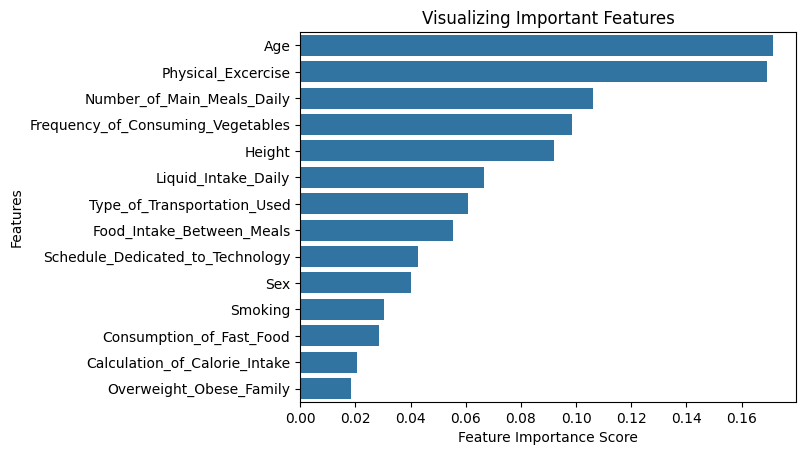

In [15]:
sns.barplot(x=feature_scores, y=feature_scores.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [34]:
# Assuming you have the feature importances from Random Forest
feature_importances = best_rf_classifier.feature_importances_
important_features = X_train.columns[np.argsort(feature_importances)[::-1]]  # Ranked by importance

# Optionally select the top N features
top_n = 12  # Adjust as needed
selected_features = important_features[:top_n]

X_train_selected = X_resampled[selected_features]
X_test_selected = X_test[selected_features]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

from sklearn.decomposition import PCA

# Initialize PCA and retain enough components to explain 95% variance
pca = PCA(n_components=0.98, random_state=42)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)

#print("X_train_resampled shape:", X_train_selected.shape)
#print("y_train_resampled shape:", y_resampled.shape)
#print("X_test_selected shape:", X_test_selected.shape)
#print("y_test shape:", y_test.shape)
#print("X_train_pca shape:", X_train_pca.shape)
#print("X_test_pca shape:", X_test_pca.shape)
#print("X_resampled shape:", X_resampled.shape)
#print("y_resampled shape:", y_resampled.shape)

Explained variance ratio: [0.29315515 0.17146855 0.12660844 0.10413836 0.09147867 0.07262173
 0.05969489 0.04883015 0.03200407]
Number of components: 9


In [35]:
best_rf_classifier.fit(X_train_pca, y_resampled)

# Evaluate on test data
accuracy = best_rf_classifier.score(X_test_pca, y_test)
print("Accuracy with PCA-transformed data:", accuracy)

Accuracy with PCA-transformed data: 0.7888198757763976
